# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.functions import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, PCA, RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime
import time

import pandas as pd
import numpy as np
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Project") \
    .getOrCreate()

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.driver.host', '814423002f65'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.port', '38803'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1631868806362'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'Sparkify Project')]

# 1. Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. 

Load and clean the dataset, checking for invalid or missing data.

In [4]:
# load dataset
df = spark.read.json("mini_sparkify_event_data.json")

In [5]:
# print the schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# print the number of rows/columns in the data
row_count = df.count()
print("The number of rows in the dataframe is {}".format(df.count()))
print("The number of columns in the dataframe is {}".format(len(df.columns)))

The number of rows in the dataframe is 286500
The number of columns in the dataframe is 18


In [7]:
df.describe(df.columns[:6]).show()

+-------+------------------+----------+---------+------+------------------+--------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|
+-------+------------------+----------+---------+------+------------------+--------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|
|   mean| 551.0852017937219|      null|     null|  null|114.41421291448516|    null|
| stddev|1217.7693079161374|      null|     null|  null|129.76726201140994|    null|
|    min|               !!!| Cancelled| Adelaida|     F|                 0|   Adams|
|    max| ÃÂlafur Arnalds|Logged Out|   Zyonna|     M|              1321|  Wright|
+-------+------------------+----------+---------+------+------------------+--------+



In [8]:
# overview of all columns
for i in df.columns:
    df.describe(i).show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+

+-------+----------+
|summary|      auth|
+-------+----------+
|  count|    286500|
|   mean|      null|
| stddev|      null|
|    min| Cancelled|
|    max|Logged Out|
+-------+----------+

+-------+---------+
|summary|firstName|
+-------+---------+
|  count|   278154|
|   mean|     null|
| stddev|     null|
|    min| Adelaida|
|    max|   Zyonna|
+-------+---------+

+-------+------+
|summary|gender|
+-------+------+
|  count|278154|
|   mean|  null|
| stddev|  null|
|    min|     F|
|    max|     M|
+-------+------+

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            286500|
|   mean|114.41421291448516|
| stddev|129.76726201140994|
|    min|                 0|
|    max| 

## Drop rows with missing values

In [9]:
# drop rows with missing values in userId or sessionId
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])

In [10]:
# total remain rows
df.count()

286500

Currently, there is no 'Nan' values in the 'userId' or 'sessionId'.

In [11]:
# drop duplicates
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



According to the above analysis, there are empty strings being user for a userId. It will be dropped.

In [12]:
df.select("sessionId").dropDuplicates().sort("sessionId").show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [13]:
#remove those with empty string userId
df = df.filter(df['userId'] != "")

In [14]:
print("The number of rows in the dataframe is {}".format(df.count()))
print("The number of columns in the dataframe is {}".format(len(df.columns)))

The number of rows in the dataframe is 278154
The number of columns in the dataframe is 18


# Exploratory Data Analysis

### Define Churn

create a column `Churn` to use as the label for the model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

## Identify churned users

In [15]:
# check cancellation confirmation page
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



Cancellation Confirmation is the page that a user is taken to they have confirmed that they would like to cancel their service. 

In [16]:
# number of churn users
df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").count()

52

In [17]:
# identify the churned user
df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").show()

+------+--------------------+
|userId|                page|
+------+--------------------+
|    18|Cancellation Conf...|
|    32|Cancellation Conf...|
|   125|Cancellation Conf...|
|   105|Cancellation Conf...|
|    17|Cancellation Conf...|
|   143|Cancellation Conf...|
|   101|Cancellation Conf...|
|   129|Cancellation Conf...|
|   121|Cancellation Conf...|
|    51|Cancellation Conf...|
|    87|Cancellation Conf...|
|   122|Cancellation Conf...|
|    12|Cancellation Conf...|
|    58|Cancellation Conf...|
|    73|Cancellation Conf...|
|     3|Cancellation Conf...|
|   106|Cancellation Conf...|
|   103|Cancellation Conf...|
|    28|Cancellation Conf...|
|    54|Cancellation Conf...|
+------+--------------------+
only showing top 20 rows



In [18]:
# Add the Churn column
churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churn", churn_event("page"))

In [19]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0)

Based on the above analysis, it can be observed that the df has added a new column termed "churn". 

**1 for churned and 0 for not churned**

In [20]:
# repeat the churn flag for all rows of the users who churned
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

# create column churn containing sum of chun 
df = df.withColumn("churn", Fsum("churn").over(windowval))

## Churn users vs. Stay users

Analyse the behaviours of churn users

In [21]:
#groupby churn users
df_churn = df.select(["userId", "churn"]).dropDuplicates().groupBy("churn").count()

In [22]:
df_churn.show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [23]:
#covert churn to pandas
df_churn = df_churn.toPandas()

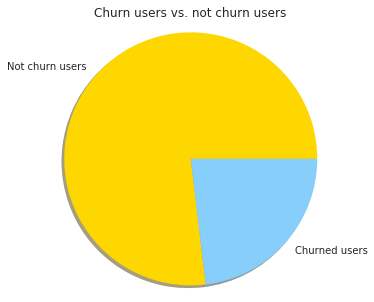

In [24]:
# plot the ratio of users who churned and others

colors = ['gold', 'lightskyblue']
groups=["Not churn users","Churned users"]

fig = plt.figure(figsize = (5,5))
plt.pie(x=df_churn["count"], labels=groups, colors=colors,shadow=True)
plt.axis('equal')
plt.title("Churn users vs. not churn users")
plt.show()

Less than a quater of all users churned.

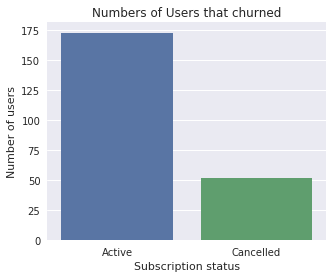

In [25]:
plt.figure(figsize = [5,4])
ax = sns.barplot(data = df_churn, x = 'churn', y='count')

plt.title("Numbers of Users that churned")
churn_d = ['Active', 'Cancelled']
x_pos = np.arange(len(churn_d))
plt.xticks(x_pos,churn_d)
plt.ylabel('Number of users')
plt.xlabel('Subscription status')
plt.show()

In [26]:
print("The ratio of churn users is {}".format(52/(173+52)))

The ratio of churn users is 0.2311111111111111


According the analysis, it can be seen that about 23.11% of total users were churned. 

## Gender effect on churn users

In this section, we will investigate the gender effect on churn users.

In [27]:
# create a gender df
df_gender = df.select(['userId', 'churn', 'gender']).dropDuplicates().groupBy('gender', 'churn').count()

In [28]:
# show gender df
df_gender.show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     F|    0|   84|
|     F|    1|   20|
|     M|    0|   89|
|     M|    1|   32|
+------+-----+-----+



In [29]:
# df_gender to pandas
df_gender = df_gender.toPandas()
df_gender

,gender,churn,count
0,F,0,84
1,F,1,20
2,M,0,89
3,M,1,32


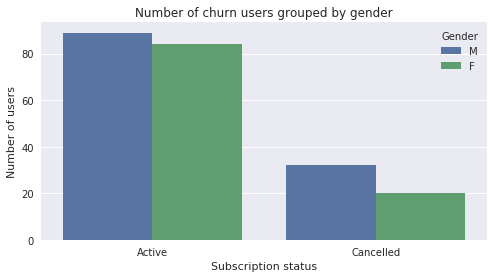

In [30]:
# sort values of gender info
df_gender = df_gender.sort_values('count', ascending = False)

# plot gender effect
plt.figure(figsize = [8,4])
ax = sns.barplot(data = df_gender, x = 'churn', y = 'count', hue = 'gender')
ax.legend(title = 'Gender')
plt.title('Number of churn users grouped by gender')

churn_d = ['Active', 'Cancelled']
x_pos = np.arange(len(churn_d))
plt.xticks(x_pos,churn_d)
plt.ylabel('Number of users')
plt.xlabel('Subscription status')
plt.show()

In [31]:
print("The ratio of male churn users is {}".format(32/(89+32)))
print("The ratio of female churn users is {}".format(20/(84+20)))

The ratio of male churn users is 0.2644628099173554
The ratio of female churn users is 0.19230769230769232


Based on the analysis, it is indicated that there are more male churn users compared with female churn users.

## Level effect

examine the level effects on churn users.

In [32]:
# leve dataframe
df_level = df.select(['userId','churn','level']).dropDuplicates().groupBy('level','churn').count()

In [33]:
df_level.show()

+-----+-----+-----+
|level|churn|count|
+-----+-----+-----+
| free|    0|  149|
| paid|    0|  129|
| free|    1|   46|
| paid|    1|   36|
+-----+-----+-----+



In [34]:
# Level effect visualisation
df_level = df_level.toPandas()

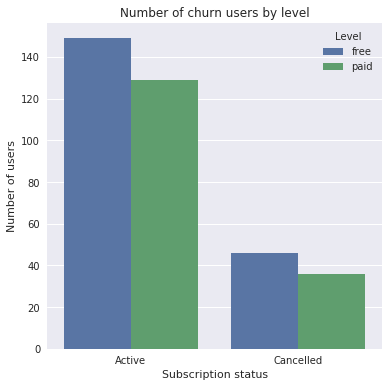

In [35]:
plt.figure(figsize = [6,6])
ax = sns.barplot(data = df_level, x = 'churn', y = 'count', hue = 'level')
ax.legend(title = 'Level')
plt.title("Number of churn users by level")

churn_d = ['Active', 'Cancelled']
x_pos = np.arange(len(churn_d))
plt.xticks(x_pos,churn_d)
plt.ylabel('Number of users')
plt.xlabel('Subscription status')
plt.show()

In [36]:
print("The ratio of free churn users is {}".format(46/(46+149)))
print("The ratio of paid churn users is {}".format(36/(129+36)))

The ratio of free churn users is 0.2358974358974359
The ratio of paid churn users is 0.21818181818181817


Therefore, free churn users are more than paid churn users.

## Pages visited by churn users/stay users

In [37]:
df_page = df.select(['userId', 'churn', 'page']).groupBy('page','churn').count()

In [38]:
df_page.show(10)

+--------------------+-----+-----+
|                page|churn|count|
+--------------------+-----+-----+
|            Settings|    0| 1244|
|         Thumbs Down|    1|  496|
|           Thumbs Up|    1| 1859|
|     Add to Playlist|    1| 1038|
|               Error|    1|   32|
|               About|    1|   56|
|         Thumbs Down|    0| 2050|
|         Roll Advert|    1|  967|
|                Home|    0| 8410|
|Cancellation Conf...|    1|   52|
+--------------------+-----+-----+
only showing top 10 rows



In [39]:
# convert
df_page = df_page.toPandas()

In [40]:
# create counts for churn users and stay users
churn_count = df_page[df_page['churn'] == 1].sum() 
stay_count = df_page[df_page['churn'] == 0].sum()

In [41]:
# the rate of pages visited by churn users vs. stay users
df_page['rate'] = np.where(
    df_page['churn'] == 0, df_page['count']/stay_count['count'], np.where(
    df_page['churn'] == 1, df_page['count']/churn_count['count'],df_page['count']/churn_count['count']))

In [42]:
df_page.head()

,page,churn,count,rate
0,Settings,0,1244,0.005332
1,Thumbs Down,1,496,0.011056
2,Thumbs Up,1,1859,0.041436
3,Add to Playlist,1,1038,0.023137
4,Error,1,32,0.000713


In [43]:
df_page['churn'].replace({0:'Active', 1: 'Cancelled'},inplace = True)

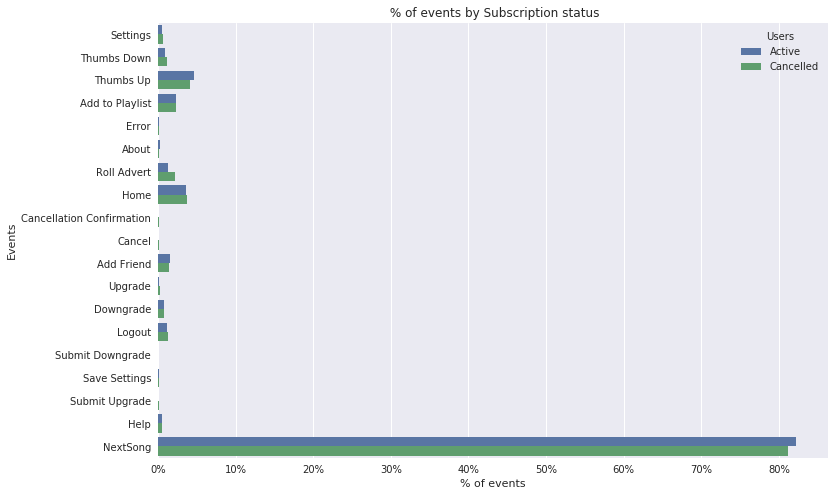

In [44]:
fig=plt.figure(figsize=(12,8))
sns.barplot(y="page", x="rate", hue="churn", data=df_page);
plt.legend(title = 'Users')
plt.ylabel('Events')
plt.xlabel('% of events')
sns.set_hls_values
plt.gca().set_xticklabels(['{:.0f}%'.format(x*10) for x in plt.gca().get_yticks()]);
plt.title(" % of events by Subscription status")
plt.show()

## Operating systems and browsers

In [45]:
# create a operating system dataframe
df_opera = df.select("userId", "userAgent", "churn").dropDuplicates(['userId'])
df_opera.show()

+------+--------------------+-----+
|userId|           userAgent|churn|
+------+--------------------+-----+
|100010|"Mozilla/5.0 (iPh...|    0|
|200002|"Mozilla/5.0 (iPh...|    0|
|   125|"Mozilla/5.0 (Mac...|    1|
|   124|"Mozilla/5.0 (Mac...|    0|
|    51|"Mozilla/5.0 (Win...|    1|
|     7|Mozilla/5.0 (Wind...|    0|
|    15|"Mozilla/5.0 (Win...|    0|
|    54|Mozilla/5.0 (Wind...|    1|
|   155|"Mozilla/5.0 (Win...|    0|
|100014|"Mozilla/5.0 (Win...|    1|
|   132|"Mozilla/5.0 (Mac...|    0|
|   154|"Mozilla/5.0 (Win...|    0|
|   101|Mozilla/5.0 (Wind...|    1|
|    11|Mozilla/5.0 (Wind...|    0|
|   138|"Mozilla/5.0 (iPa...|    0|
|300017|"Mozilla/5.0 (Mac...|    0|
|100021|"Mozilla/5.0 (Mac...|    1|
|    29|"Mozilla/5.0 (Mac...|    1|
|    69|"Mozilla/5.0 (Win...|    0|
|   112|Mozilla/5.0 (Wind...|    0|
+------+--------------------+-----+
only showing top 20 rows



In [46]:
# convert to pandas
df_opera = df_opera.toPandas()

In [47]:
df_opera.head()

,userId,userAgent,churn
0,100010,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",0
1,200002,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1 like M...",0
2,125,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1
3,124,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",0
4,51,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",1


In [48]:
# create a operation sys list
opera_list = ["Windows", "Mac", "Linux", "iPhone", "iPad"]

# add a column for operation sys, extract strings
df_opera['operateSys'] = df_opera.userAgent.str.extract('(?i)({0})'.format('|'.join(opera_list))) 

In [49]:
df_opera.head(10)

,userId,userAgent,churn,operateSys
0,100010,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",0,iPhone
1,200002,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1 like M...",0,iPhone
2,125,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1,Mac
3,124,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",0,Mac
4,51,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",1,Windows
5,7,Mozilla/5.0 (Windows NT 6.1; rv:31.0) Gecko/20...,0,Windows
6,15,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",0,Windows
7,54,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,1,Windows
8,155,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",0,Windows
9,100014,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",1,Windows


In [50]:
operateSys_order = df_opera.operateSys.value_counts().index

In [51]:
df_opera['churn'].replace({0:'Active', 1: 'Cancelled'},inplace = True)

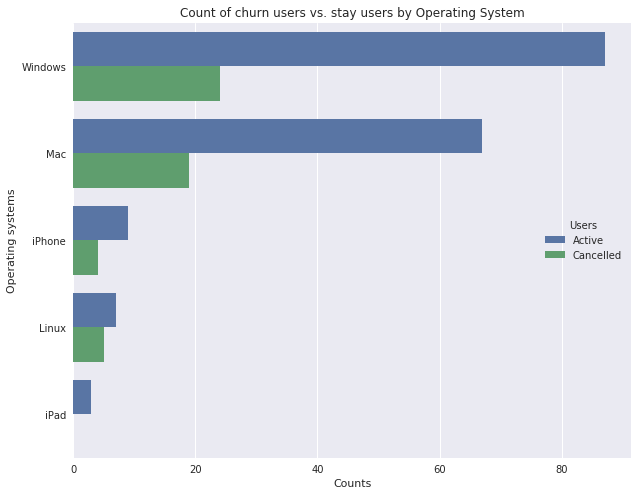

In [52]:
# plot count for churn and non churn users
plt.figure(figsize=[10,8])
sns.countplot(data = df_opera, y = 'operateSys', hue ='churn', order = operateSys_order)
plt.title('Count of churn users vs. stay users by Operating System')
plt.legend(title = 'Users')
plt.ylabel('Operating systems')
plt.xlabel('Counts')
plt.show()

It can be observed that Linux users have the highest rate of churn.

In [53]:
browser_list = ["Chrome", "Firefox", "Safari", "Trident"]

In [54]:
df_opera['browser'] = df_opera.userAgent.str.extract('(?i)({0})'.format('|'.join(browser_list)))

In [55]:
df_opera.browser.value_counts()

Chrome     117
Firefox     50
Safari      46
Trident     12
Name: browser, dtype: int64

In [56]:
df_opera.head()

,userId,userAgent,churn,operateSys,browser
0,100010,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",Active,iPhone,Safari
1,200002,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1 like M...",Active,iPhone,Safari
2,125,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Cancelled,Mac,Chrome
3,124,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Active,Mac,Chrome
4,51,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Cancelled,Windows,Chrome


In [57]:
browser_order = df_opera.browser.value_counts().index

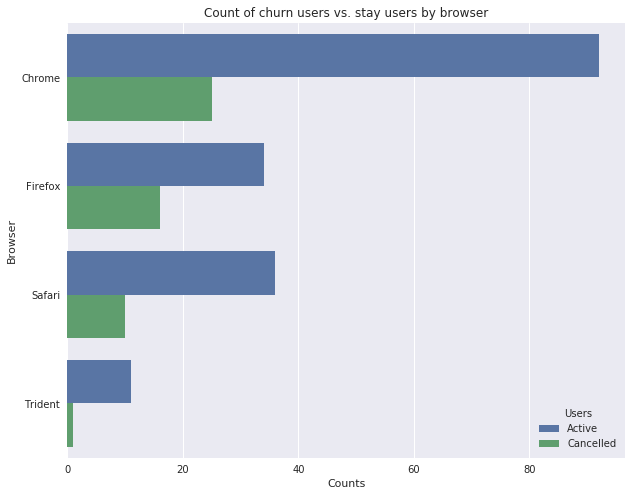

In [58]:
plt.figure(figsize=[10,8])
sns.countplot(data = df_opera, y = 'browser', hue ='churn', order = browser_order)
plt.title('Count of churn users vs. stay users by browser')
plt.legend(title = 'Users')
plt.ylabel('Browser')
plt.xlabel('Counts')
plt.show()

Chrome was the most popular browser. 

Firefox users were most likely to churn. 


# Feature Engineering

The features we will build out are:

- gender
- number of songs per session
- number of rollads actions
- number of thumb up actions
- number of thumbs down actions
- number of friends added
- number of songs added to playlist
- number of different artists listened to on Sparkify
- level (paid/free)


A churn label will be added and join these all together. 

After drop the userId column, this dataframe can be vectorised, standarised and fed into different machine learning algorithms.

## Ten Features

### Feature 1: Gender

In [59]:
# Feature 1: Gender
f1_gender = df.select(['userId', 'gender']).dropDuplicates()\
           .withColumn('gender', when(col('gender') == 'F', 1).otherwise(0))

In [60]:
f1_gender.show(5)
print("rows count: ", f1_gender.count())
f1_gender

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
+------+------+
only showing top 5 rows

rows count:  225


DataFrame[userId: string, gender: int]

### Feature 2: number of songs per session

In [61]:
# Feature 2: averge_song
f2_song = df.filter(df.page == 'NextSong').groupBy('userId', 'sessionId').count()\
          .groupby('userId').agg({"count":"avg"})

In [62]:
f2_song = f2_song.withColumnRenamed("avg(count)", "avg_song")

In [63]:
f2_song.show(5)
print("rows count: ", f2_song.count())
f2_song

+------+------------------+
|userId|          avg_song|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
+------+------------------+
only showing top 5 rows

rows count:  225


DataFrame[userId: string, avg_song: double]

### Feature 3: number of roll advert actions

In [64]:
# Feature 3:  Roll advert
rollad_event = udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())
f3_rollad = df.select('userId', 'page').withColumn("rollad", rollad_event("page"))

In [65]:
f3_rollad = f3_rollad.groupby('userId').sum("rollad").withColumnRenamed("sum(rollad)", "roll_ad")

In [66]:
f3_rollad.show(5)
print("rows count: ", f3_rollad.count())
f3_rollad

+------+-------+
|userId|roll_ad|
+------+-------+
|100010|     52|
|200002|      7|
|   125|      1|
|    51|      0|
|   124|      4|
+------+-------+
only showing top 5 rows

rows count:  225


DataFrame[userId: string, roll_ad: bigint]

### Feature 4: Thumb up

In [67]:
# Feature 4: Thumb up
f4_thumbup = df.select(["userId", "page"])

In [68]:
thumbup_event = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())

In [69]:
f4_thumbup = f4_thumbup.withColumn("Thumbs Up", thumbup_event("page")).groupby('userId').sum("Thumbs Up")

In [70]:
f4_thumbup = f4_thumbup.withColumnRenamed("sum(Thumbs Up)", "thumbs_up")

In [71]:
f4_thumbup.show(5)
print("rows count: ", f4_thumbup.count())
f4_thumbup

+------+---------+
|userId|thumbs_up|
+------+---------+
|100010|       17|
|200002|       21|
|   125|        0|
|    51|      100|
|   124|      171|
+------+---------+
only showing top 5 rows

rows count:  225


DataFrame[userId: string, thumbs_up: bigint]

### Feature 5: Thumb down

In [72]:
# Feature 5: Thumb down
f5_thumbdown = df.select(["userId", "page"])

In [73]:
thumbdown_event = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())

In [74]:
f5_thumbdown = f5_thumbdown.withColumn("Thumbs Down", thumbdown_event("page")).groupby('userId').sum("Thumbs Down")

In [75]:
f5_thumbdown = f5_thumbdown.withColumnRenamed("sum(Thumbs Down)", "thumbs_down")

In [76]:
f5_thumbdown.show(5)
print("rows count: ", f5_thumbdown.count())
f5_thumbdown

+------+-----------+
|userId|thumbs_down|
+------+-----------+
|100010|          5|
|200002|          6|
|   125|          0|
|    51|         21|
|   124|         41|
+------+-----------+
only showing top 5 rows

rows count:  225


DataFrame[userId: string, thumbs_down: bigint]

### Feature 6: add friends

In [81]:
# Feature 6: Added friends
f6_friend = df.select(["userId", "page"])

In [82]:
add_friend = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())

In [83]:
f6_friend = f6_friend.withColumn("add_friend", add_friend("page")).groupby('userId').sum("add_friend")

In [84]:
f6_friend = f6_friend.withColumnRenamed("sum(add_friend)", "add_friend")

In [85]:
f6_friend.show(5)
print("rows count: ", f6_friend.count())
f6_friend

+------+----------+
|userId|add_friend|
+------+----------+
|100010|         4|
|200002|         4|
|   125|         0|
|    51|        28|
|   124|        74|
+------+----------+
only showing top 5 rows

rows count:  225


DataFrame[userId: string, add_friend: bigint]

### Feature 7: Number of songs added to playlist

In [86]:
# Feature 7: Number of songs added to playlist
f7_playlist = df.select(["userId", "page"])

In [87]:
add_playlist = udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())

In [88]:
f7_playlist = f7_playlist.withColumn("Playlist", add_playlist("page")).groupby('userId').sum("Playlist")

In [89]:
f7_playlist = f7_playlist.withColumnRenamed("sum(Playlist)", "playlist")

In [90]:
f7_playlist.show(5)
print("rows count: ", f7_playlist.count())
f7_playlist

+------+--------+
|userId|playlist|
+------+--------+
|100010|       7|
|200002|       8|
|   125|       0|
|    51|      52|
|   124|     118|
+------+--------+
only showing top 5 rows

rows count:  225


DataFrame[userId: string, playlist: bigint]

### Feature 8: Number of different artists

In [91]:
# Feature 8: Number of different artisits
f8_artists = df.select("userId", "artist").dropDuplicates() \
         .groupby("userId").count().withColumnRenamed("count", "num_artists")

In [92]:
f8_artists.show(5)
print("rows count: ", f8_artists.count())
f8_artists

+------+-----------+
|userId|num_artists|
+------+-----------+
|100010|        253|
|200002|        340|
|   125|          9|
|    51|       1386|
|   124|       2233|
+------+-----------+
only showing top 5 rows

rows count:  225


DataFrame[userId: string, num_artists: bigint]

### Feature 9: Level (free/paid)

In [93]:
# Feature 9: Level (free/paid)
f9_level = df.select(['userId', 'level', 'ts']).dropDuplicates().sort('userId')

In [94]:
w = Window.partitionBy("userId").orderBy(desc("ts"))

In [95]:
f9_level = f9_level.withColumn("Rank", dense_rank().over(w))

In [96]:
f9_level = f9_level.filter(f9_level.Rank == 1).drop(f9_level.Rank)

In [97]:
f9_level = f9_level.drop('ts')

In [98]:
f9_level = f9_level.withColumn('level', when(col('level') == 'paid', 1).otherwise(0))

In [99]:
f9_level.show(5)
print("rows count: ", f9_level.count())
f9_level

+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
+------+-----+
only showing top 5 rows

rows count:  225


DataFrame[userId: string, level: int]

### Label column to present churn users

In [100]:
# create label column indicating churn or not.
label = df.select("userId", "churn").dropDuplicates().groupby("userId", "churn").count()

In [101]:
label = label.drop('count')

In [102]:
label.count()

225

In [103]:
label = label.withColumnRenamed("churn", "label")

In [105]:
label.show(5)
print("rows count: ", label.count())
label

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
+------+-----+
only showing top 5 rows

rows count:  225


DataFrame[userId: string, label: bigint]

### Create a feature_df

In [106]:
#feature
feature_df = f1_gender.join(f2_song, ["userId"])  \
             .join(f3_rollad, ["userId"])\
             .join(f4_thumbup, ["userId"])\
             .join(f5_thumbdown,["userId"])\
             .join(f6_friend, ["userId"])\
             .join(f7_playlist, ["userId"])\
             .join(f8_artists, ["userId"])\
             .join(f9_level, ["userId"])\
             .join(label, ["userId"])

In [107]:
feature_df.show()

+------+------+------------------+-------+---------+-----------+----------+--------+-----------+-----+-----+
|userId|gender|          avg_song|roll_ad|thumbs_up|thumbs_down|add_friend|playlist|num_artists|level|label|
+------+------+------------------+-------+---------+-----------+----------+--------+-----------+-----+-----+
|100010|     1|39.285714285714285|     52|       17|          5|         4|       7|        253|    0|    0|
|200002|     0|              64.5|      7|       21|          6|         4|       8|        340|    1|    0|
|   125|     0|               8.0|      1|        0|          0|         0|       0|          9|    0|    1|
|   124|     1|145.67857142857142|      4|      171|         41|        74|     118|       2233|    1|    0|
|    51|     0|             211.1|      0|      100|         21|        28|      52|       1386|    1|    1|
|     7|     0|21.428571428571427|     16|        7|          1|         1|       5|        143|    0|    0|
|    15|     0|136.

In [108]:
feature_df = feature_df.drop('userId')

In [109]:
feature_df.show()

+------+------------------+-------+---------+-----------+----------+--------+-----------+-----+-----+
|gender|          avg_song|roll_ad|thumbs_up|thumbs_down|add_friend|playlist|num_artists|level|label|
+------+------------------+-------+---------+-----------+----------+--------+-----------+-----+-----+
|     1|39.285714285714285|     52|       17|          5|         4|       7|        253|    0|    0|
|     0|              64.5|      7|       21|          6|         4|       8|        340|    1|    0|
|     0|               8.0|      1|        0|          0|         0|       0|          9|    0|    1|
|     1|145.67857142857142|      4|      171|         41|        74|     118|       2233|    1|    0|
|     0|             211.1|      0|      100|         21|        28|      52|       1386|    1|    1|
|     0|21.428571428571427|     16|        7|          1|         1|       5|        143|    0|    0|
|     0|136.71428571428572|      1|       81|         14|        31|      59|     

In [110]:
# print schema
feature_df.printSchema()

root
 |-- gender: integer (nullable = false)
 |-- avg_song: double (nullable = true)
 |-- roll_ad: long (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- add_friend: long (nullable = true)
 |-- playlist: long (nullable = true)
 |-- num_artists: long (nullable = false)
 |-- level: integer (nullable = false)
 |-- label: long (nullable = true)



In [111]:
for feature in feature_df.columns:
    feature_df = feature_df.withColumn(feature, feature_df[feature].cast('float'))

In [112]:
#check this works
feature_df.printSchema()

root
 |-- gender: float (nullable = false)
 |-- avg_song: float (nullable = true)
 |-- roll_ad: float (nullable = true)
 |-- thumbs_up: float (nullable = true)
 |-- thumbs_down: float (nullable = true)
 |-- add_friend: float (nullable = true)
 |-- playlist: float (nullable = true)
 |-- num_artists: float (nullable = false)
 |-- level: float (nullable = false)
 |-- label: float (nullable = true)



### Vector

In [113]:
assembler = VectorAssembler(
    inputCols = ["gender", "avg_song", "roll_ad", \
                 "thumbs_up", "thumbs_down", "add_friend", \
                 "playlist", "num_artists", "level"], \
    outputCol = "vec_features")

In [114]:
feature_df = assembler.transform(feature_df)

### Standarlisation process

In [115]:
scaler = StandardScaler(inputCol="vec_features", outputCol="features", withStd = True)

In [116]:
scaler_model = scaler.fit(feature_df)

In [117]:
feature_df = scaler_model.transform(feature_df)

In [118]:
feature_df.head(2)

[Row(gender=1.0, avg_song=39.28571319580078, roll_ad=52.0, thumbs_up=17.0, thumbs_down=5.0, add_friend=4.0, playlist=7.0, num_artists=253.0, level=0.0, label=0.0, vec_features=DenseVector([1.0, 39.2857, 52.0, 17.0, 5.0, 4.0, 7.0, 253.0, 0.0]), features=DenseVector([2.0013, 0.9219, 2.413, 0.2596, 0.3823, 0.1943, 0.214, 0.4189, 0.0])),
 Row(gender=0.0, avg_song=64.5, roll_ad=7.0, thumbs_up=21.0, thumbs_down=6.0, add_friend=4.0, playlist=8.0, num_artists=340.0, level=1.0, label=0.0, vec_features=DenseVector([0.0, 64.5, 7.0, 21.0, 6.0, 4.0, 8.0, 340.0, 1.0]), features=DenseVector([0.0, 1.5135, 0.3248, 0.3207, 0.4588, 0.1943, 0.2445, 0.563, 2.0844]))]

### Train Test Spliting

In [119]:
# split the feature set into train (60%), test(20%) and validation (20%) sets
train, test, valid = feature_df.randomSplit([0.6, 0.2, 0.2], seed = 1996)

In [117]:
print("Training Dataset: " , str(train.count()))
print("Test Dataset: " , str(test.count()))
#print("Validation Dataset :" , str(valid.count()))

Training Dataset:  188
Test Dataset:  37


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

## Models

In [120]:
# Instantiate all of the models

#LR
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)

# random forest
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed=100)

# GBT 
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxIter=10, seed=100)

# SVM
svm = LinearSVC(featuresCol = 'features', labelCol = 'label', maxIter = 10,  regParam = 0.01)

# Bayes
bayes = NaiveBayes(featuresCol = 'features', labelCol = 'label')

In [121]:
#list of models
model_list = [lr,rf,gbt,svm,bayes]

In [122]:
# evaluator
evaluator = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol='prediction')

## Computing

In [123]:
# for loop to go through all our models
for model in model_list:
    # get model name 
    model_name = model.__class__.__name__
    
    # print training started
    print(model_name, 'training started')
    
    # start time
    start = time.time()
    # fit the models on train dataset
    model = model.fit(train)
    # end time
    end = time.time()
     
    # print training ended
    print(model_name, 'training ended')
    # print time taken
    print('Time taken for {} is:'.format(model_name),(end-start),'seconds')
    
    # predict
    print(model_name, 'predicting started')
    predictions = model.transform(valid)
    print(model_name, 'predicting ended')
    
    # get metrics to evaluate
    # f1
    print('F1 for {} is:'.format(model_name), evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))
    # accuracy
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / (predictions.count())
    print("The accuracy of the {} model is:".format(model_name), accuracy)
    
    print("*" * 80)

LogisticRegression training started
LogisticRegression training ended
Time taken for LogisticRegression is: 85.13246321678162 seconds
LogisticRegression predicting started
LogisticRegression predicting ended
F1 for LogisticRegression is: 0.6523297491039427
The accuracy of the LogisticRegression model is: 0.7222222222222222
********************************************************************************
RandomForestClassifier training started
RandomForestClassifier training ended
Time taken for RandomForestClassifier is: 146.05924725532532 seconds
RandomForestClassifier predicting started
RandomForestClassifier predicting ended
F1 for RandomForestClassifier is: 0.6523297491039427
The accuracy of the RandomForestClassifier model is: 0.7222222222222222
********************************************************************************
GBTClassifier training started
GBTClassifier training ended
Time taken for GBTClassifier is: 199.45962357521057 seconds
GBTClassifier predicting started
GBTCla

## Model tuning for best  models

In [125]:
# numTrees and maxDepth for tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees,[20, 50, 100]) \
    .addGrid(rf.maxDepth,[5, 10, 15]) \
    .build()


crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName = "f1"),
                          numFolds=3)

In [126]:
%%time
cvModel = crossval.fit(train)

CPU times: user 10.8 s, sys: 3.45 s, total: 14.3 s
Wall time: 40min 12s


### Performance results:

In [127]:
results = cvModel.transform(valid)

In [128]:
accuracy = results.filter(results.label == results.prediction).count() / (results.count())

In [129]:
best_model = cvModel.bestModel

In [130]:
print ("Best Param (numTrees): ", best_model._java_obj.getNumTrees())
print ("Best Param (MaxDepth): ", best_model._java_obj.getMaxDepth())

Best Param (numTrees):  100
Best Param (MaxDepth):  5


In [145]:
# f1 and accuracy
print('F1 for the model is:', evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))
print('Accuracy for the model is:', evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))

F1 for the model is: 0.6805555555555557
Accuracy for the model is: 0.7777777777777778


### Feature importance:

importance feature for the model

In [132]:
# feature importances
important_feature = best_model.featureImportances

In [134]:
x_values = list(range(len(important_feature)))

In [135]:
# feature list
feature_list = list(["gender", "avg_song", "roll_ad", \
                 "thumbs_up", "thumbs_down", "add_friend", \
                 "playlist", "num_artists", "level"])

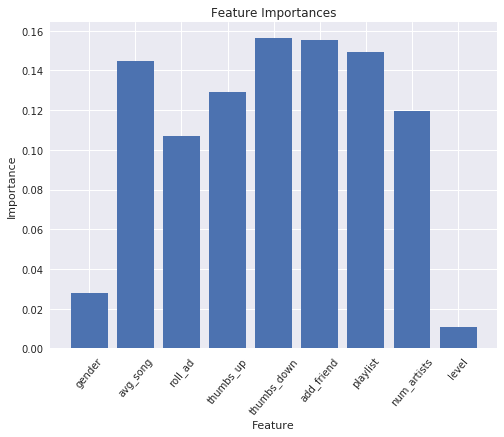

In [143]:
# ploting fig
plt.figure(figsize=[8,6])
plt.bar(x_values, important_feature, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=50)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances');

# Conclusions

We started the project with a small dataset. After loading and cleaning data, we explored the dataset for useful features to predict churn and were able to build out the most important features.Then, we preprocessed these and used the features with different machine learning algorithms. 

The project involved:

- Loading and cleaning a small subset (128MB) of a full dataset available (12GB)
- Exploratory Data Analysis to understand the data and what features are useful for predicting churn
- Feature Engineering to create features that will be used in the modelling process
- Modelling using machine learning algorithms 

## Business impact

Sparkify can use above information to target customers who are likely to churn and offer attractive incentives to stay, thereby saving Sparkify revenue and getting the customer a nice deal. 

- Free trail of premium services for new customers
- Optimise recommendation system 



## Future works

This project can be improved :

- Real-time monitoring customer behaviors, make this data as input layer to train ML model and subsequently recommend more interesting music/services for customers

- Collecting up-to-date info from news/web/other media, and push the most-popular new songs to customers